In [106]:
import posixpath
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
from shapely.geometry import Polygon
from shapely import plotting
import matplotlib.pyplot as plt
import datetime
import scipy

## Load datasets and count glaciers

In [107]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
kh_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [108]:
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
landsat_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446917.357 8830600.499, 446900.231..."
1,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447150.28 8832426.203, 447136.579 ..."
2,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446105.553 8836403.019, 446122.679..."
3,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00794,RGI2000-v7.0-G-07-01268,5,NE,"LINESTRING (445687.662 8843966.161, 445629.431..."
4,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00790,RGI2000-v7.0-G-07-01266,6,NE,"LINESTRING (442212.658 8844269.303, 442116.749..."


In [109]:
all_fronts = pd.concat([kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [110]:
print(len(all_fronts.RGI70ID.value_counts()), "glaciers observed")
print(len(all_fronts.front_id.value_counts()), "fronts observed")

167 glaciers observed
181 fronts observed


## Uncertainties and results with a personal method to measure front displacements

### First test on a specific front

In [111]:
fronts_i = all_fronts.loc[all_fronts.front_id == 141]
fronts_i

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
52,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (706193.565 8667750.728, 706858.008..."
110,DS09058A024MC013,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (713675.271 8637225.816, 713845.731..."
715,LM02_L1GS_224004_19760712_20200907_02_T2,Landsat 2 MSS,1976-07-12,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700538.395 8663991.175, 700557.27 ..."
727,LM02_L1GS_228003_19760716_20200907_02_T2,Landsat 2 MSS,1976-07-16,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (701120.513 8663051.852, 701013.526..."
743,LM02_L1GS_230003_19760718_20200907_02_T2,Landsat 2 MSS,1976-07-18,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700836.202 8663548.992, 700863.965..."


area : 68609359.55143876 distance : 1032.4789928686012
distance from dot prod : -1702.3486011934392 , direction : -1.0


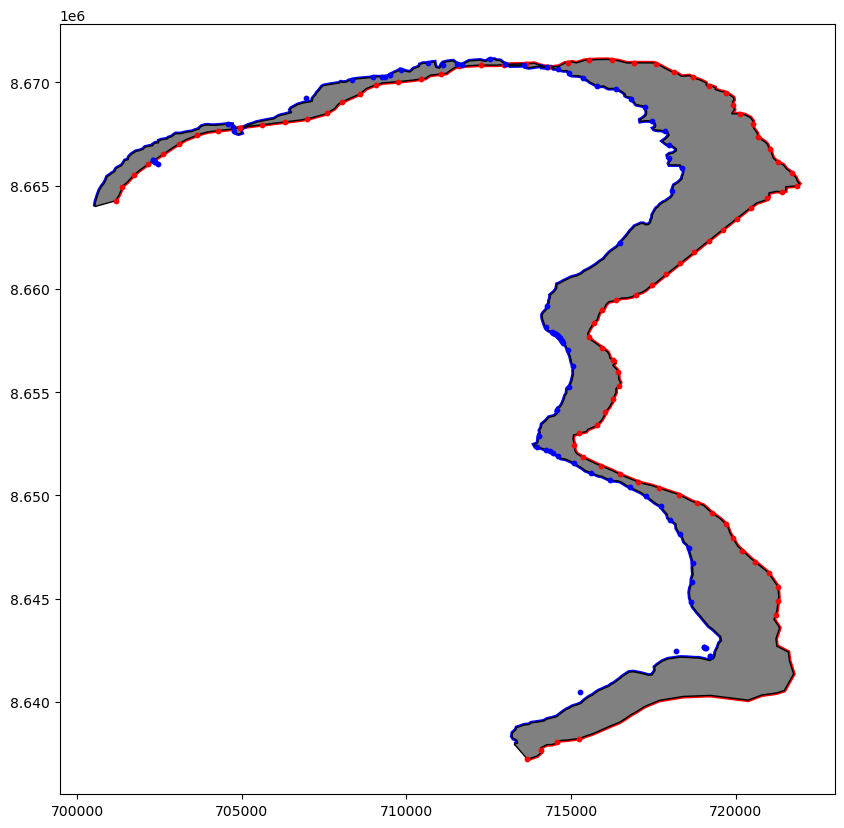

In [112]:
i1, i2 = 1, 2

front1, front2 = fronts_i.iloc[i1].geometry, fronts_i.iloc[i2].geometry
dir1, dir2 = fronts_i.iloc[i1].front_dir, fronts_i.iloc[i2].front_dir
u = np.array([1, 1]) / np.sqrt(2)

## absolute distance
# print("length imbalance :", np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]))
# polygon1 = Polygon(list(front1.coords) + list(front2.coords))
# area1 = polygon1.area
# polygon2 = Polygon(list(front1.coords) + list(front2.coords)[::-1])
# area2 = polygon2.area
# print("area imbalance :", np.abs(area1 - area2)/np.max([area1, area2]))
# d1 = area1/((front1.length + front2.length)/2)
# d2 = area2/((front1.length + front2.length)/2)
# print("distances :", d1, d2)

points_1 = [shapely.Point(coords) for coords in front1.coords]
points_2 = [shapely.Point(coords) for coords in front2.coords]

if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
    points_2 = points_2[::-1]
    front2 = shapely.LineString(points_2)
    
polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
area = polygon.area
d = area / ((front1.length + front2.length) / 2)
print("area :", area, "distance :", d)

## direction
# middle of extreme points → not working
# c1 = (np.array(front1.coords)[0] + np.array(front1.coords)[-1])/2
# c2 = (np.array(front2.coords)[0] + np.array(front2.coords)[-1])/2

# centroids → works but a lot of rejections
# c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
# c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])

# center of the font → not working well
# c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
# c2 = np.array([front2.interpolate(0.5 * front2.length).x, front2.interpolate(0.5 * front2.length).y])

# dot_prod = np.dot(c2-c1, u)#/ np.linalg.norm(c2-c1)
# sgn = np.sign(dot_prod)
# print("dot product :", dot_prod, "sign :", sgn)

# center of the front1 + using flow direction → probably the best solution
points_interp_1 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
points_interp_2 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
for i in range(len(points_interp_1)):
    l = ll.geoms[i]
    point_interp_2_i = shapely.intersection(front2, l)
    
    if point_interp_2_i.is_empty:
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
        
    elif isinstance(point_interp_2_i, shapely.Point):
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
    
    elif isinstance(point_interp_2_i, shapely.MultiPoint):
        point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
        point_interp_2_i = shapely.Point(point_interp_2_i)
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
points_interp.dropna(inplace=True)

# points_interp
points_interp.loc[:, "x21"] = points_interp.loc[:, "x2"] - points_interp.loc[:, "x1"]
points_interp.loc[:, "y21"] = points_interp.loc[:, "y2"] - points_interp.loc[:, "y1"]
dot_prod = points_interp.loc[:, ["x21", "y21"]].apply(lambda z: z.x21 * u[0] + z.y21 * u[1], axis=1)
points_interp.loc[:, "dot_prod"] = dot_prod
sgn = np.sign(points_interp.dot_prod.mean())

print("distance from dot prod :", dot_prod.mean() , ", direction :", sgn)

## plots
# fig, axs = plt.subplots(ncols=2, figsize=[10, 6])
# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_polygon(polygon1, facecolor="gray", edgecolor="k", add_points=False, ax=axs[0])
# # axs[0].scatter(c1[0], c1[1], color="red")
# # axs[0].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[0])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[0])
# axs[0].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[0].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_polygon(polygon2, facecolor="gray", edgecolor="k", add_points=False, ax =axs[1])
# # axs[1].scatter(c1[0], c1[1], color="red")
# # axs[1].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[1])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[1])
# axs[1].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[1].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_polygon(polygon, facecolor="gray", edgecolor="k", add_points=False, ax=ax)
ax.scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
ax.scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

### Definition of general functions to do it

In [113]:
# def distance_abs(front1, front2):
#     '''
#     Calculates the absolute distance between two fronts, by dividing the area of the polygon by the mean length.
#     If the front lengths are too different (50%), returns None.
#     '''
#     if np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]) >= 0.5:
#         return None
#     else:
#         polygon1 = Polygon(list(front1.coords) + list(front2.coords))
#         area1 = polygon1.area
#         polygon2 = Polygon(list(front1.coords) + list(front2.coords)[::-1])
#         area2 = polygon2.area
#         return 2 * np.min([area1, area2]) / (front1.length + front2.length)
    
# def distance(front1, front2, dir_1, dir_2):
#     '''
#     Calculates the signed distance between two fronts, using flow direction.
#     returns a tuple (distance, error_code):
#     - distance: the signed distance between the fronts, or None if the fronts are too different
#     - error_code: 0 = everything is ok,, 1 = front lengths are too different, 2 = direction is inaccurate 
#     '''
#     assert dir_1 == dir_2, "Fronts must have the same direction" # not necessary for the calculation, just sanitary check.
#     dist_abs = distance_abs(front1, front2)
#     if dist_abs is None:
#         return None, 1
#     else:
#         # transform direction into av vector:
#         if dir_1 == "N":
#             dir_vector = np.array([0, 1])
#         elif dir_1 == "S":
#             dir_vector = np.array([0, -1])
#         elif dir_1 == "E":
#             dir_vector = np.array([1, 0])
#         elif dir_1 == "W":
#             dir_vector = np.array([-1, 0])
#         elif dir_1 == "NE":
#             dir_vector = np.array([1, 1]) / np.sqrt(2)
#         elif dir_1 == "NW":
#             dir_vector = np.array([-1, 1]) / np.sqrt(2)
#         elif dir_1 == "SE":
#             dir_vector = np.array([1, -1]) / np.sqrt(2)
#         elif dir_1 == "SW":
#             dir_vector = np.array([-1, -1]) / np.sqrt(2)
#         else:
#             raise ValueError(f"Unknown direction: {dir_1}")
        
#         # old method with centroids
#         # c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
#         # c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])
        
#         # dot_prod = np.dot(c2-c1, dir_vector)/ np.linalg.norm(c2-c1)
        
#         # if np.abs(dot_prod) < np.sqrt(2)/2:
#         #     return None, 2
#         # else:
#         #     return np.sign(dot_prod) * dist_abs, 0
        
#         c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
#         l = shapely.LineString(np.stack([c1 - dir_vector * 50000, c1, c1 + dir_vector * 50000]))
#         c2_s = shapely.intersection(front2, l)
        
        
#         if c2_s.is_empty or isinstance(c2_s, shapely.geometry.multipoint.MultiPoint):
#             return None, 2
#         else:
#             c2 = np.array([c2_s.x, c2_s.y])
#             dot_prod = np.dot(c2-c1, dir_vector) #/ np.linalg.norm(c2-c1) # normalisation can be removed to give an extra assessment of the distance.
#             return np.sign(dot_prod) * dist_abs, 0

def distance_abs(front1, front2):
    '''
    Calculates the absolute distance between two fronts, by dividing the area of the polygon by the mean length.
    If the front lengths are too different (50%), returns None.
    '''
    if np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]) >= 0.5:
        return None
    else:
        points_1 = [shapely.Point(coords) for coords in front1.coords]
        points_2 = [shapely.Point(coords) for coords in front2.coords]

        if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
            points_2 = points_2[::-1]
            front2 = shapely.LineString(points_2)
            
        polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
        area = polygon.area
        d = area / ((front1.length + front2.length) / 2)
        return 2 * area / (front1.length + front2.length)
    
def distance_sgn(front1, front2, u):
    points_interp_1 = pd.DataFrame(
        [],
        columns=["points", "x", "y"]
    )
    points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
    points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
    ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
    points_interp_2 = pd.DataFrame(
        [],
        columns=["points", "x", "y"]
    )
    for i in range(len(points_interp_1)):
        l = ll.geoms[i]
        point_interp_2_i = shapely.intersection(front2, l)
        
        if point_interp_2_i.is_empty:
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
            
        elif isinstance(point_interp_2_i, shapely.Point):
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
        
        elif isinstance(point_interp_2_i, shapely.MultiPoint):
            point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
            point_interp_2_i = shapely.Point(point_interp_2_i)
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

    points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
    points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
    points_interp.dropna(inplace=True)
    
    if len(points_interp) == 0:
        return None
    else:
        dot_prod = points_interp.loc[:, ["x1", "y1", "x2", "y2"]].apply(lambda z: (z.x2 - z.x1) * u[0] + (z.y2 - z.y1) * u[1], axis=1)
        sgn = np.sign(dot_prod.mean())
        return sgn

def distance(front1, front2, dir_1, dir_2):
    assert dir_1 == dir_2, "Fronts must have the same direction" # not necessary for the calculation, just sanitary check.
    dist_abs = distance_abs(front1, front2)
    if dist_abs is None:
        return None, 1
    else:
        # transform direction into av vector:
        if dir_1 == "N":
            u = np.array([0, 1])
        elif dir_1 == "S":
            u = np.array([0, -1])
        elif dir_1 == "E":
            u = np.array([1, 0])
        elif dir_1 == "W":
            u = np.array([-1, 0])
        elif dir_1 == "NE":
            u = np.array([1, 1]) / np.sqrt(2)
        elif dir_1 == "NW":
            u = np.array([-1, 1]) / np.sqrt(2)
        elif dir_1 == "SE":
            u = np.array([1, -1]) / np.sqrt(2)
        elif dir_1 == "SW":
            u = np.array([-1, -1]) / np.sqrt(2)
        else:
            raise ValueError(f"Unknown direction: {dir_1}")
        
        sgn = distance_sgn(front1, front2, u)
        
        if sgn is None:
            return None, 2
        else:       
            return sgn * dist_abs, 0

### Uncertainties

KH

Timestamp: 1962-05-16 00:00:00, Mean distance: -18.14 m, Standard deviation: 539.68 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -24.31 m, Standard deviation: 225.01 m
Skipped 40 (2 direction and 38 length) comparisons out of 516.


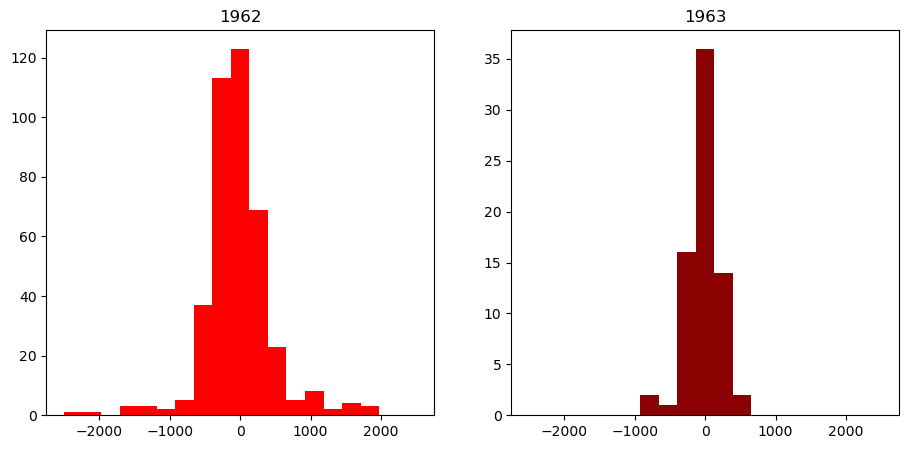

In [114]:
dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distance(front1, front2, dir_1, dir_2)
                if dist == np.nan:
                    print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                if dist is not None:
                    dists_timestamp.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"))
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"))
# fig.suptitle("Distribution of distances between KH-5 ARGON fronts")
fig.savefig("images/KH-5_ARGON_fonts_accuracy.png", bbox_inches="tight")

Landsat

Year: 1976, Mean distance: -8.96 m, Standard deviation: 80.70 m
Year: 1978, Mean distance: 16.64 m, Standard deviation: 117.93 m
Skipped 59 (0 direction and 59 length) comparisons out of 337.


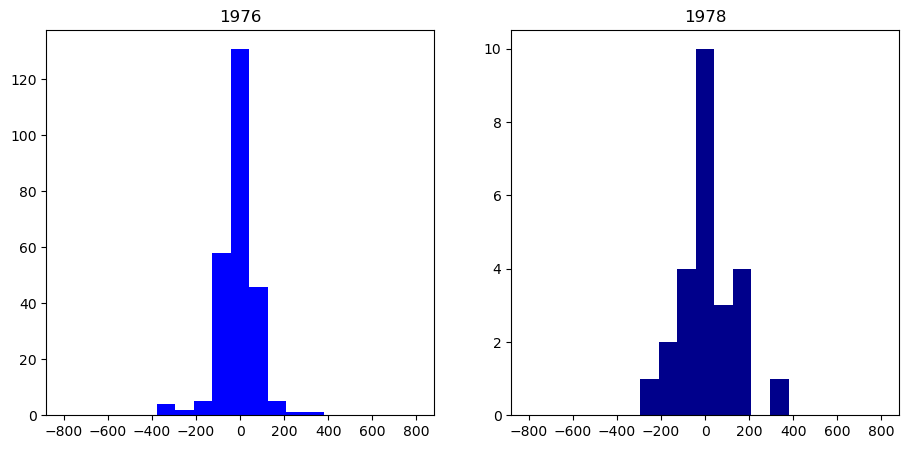

In [115]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distance(front1, front2, dir_1, dir_2)
                if dist is not None:
                    dists_year.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(years), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0])
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1])
# fig.suptitle("Distribution of distances between Landsat MSS fronts")
fig.savefig("images/Landsat_MSS_fonts_accuracy.png", bbox_inches="tight")

Recompile uncertainties

In [11]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[539. 225.  80. 117.] [381. 159.  56.  82.]


In [12]:
uncertainties = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties.loc[len(uncertainties)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        
uncertainties.loc[:, "years"] = uncertainties.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties = uncertainties[["year_1", "year_2", "years", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties

,year_1,year_2,years,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,"(1962.0, 1962.0)",538.815367,1077.630735,1616.446102
1,1962.0,1963.0,"(1962.0, 1963.0)",412.846218,825.692437,1238.538655
2,1962.0,1976.0,"(1962.0, 1976.0)",385.093495,770.186990,1155.280485
3,1962.0,1978.0,"(1962.0, 1978.0)",389.724261,779.448523,1169.172784
4,1963.0,1963.0,"(1963.0, 1963.0)",224.859956,449.719913,674.579869
5,1963.0,1976.0,"(1963.0, 1976.0)",168.573426,337.146852,505.720278
6,1963.0,1978.0,"(1963.0, 1978.0)",178.899413,357.798826,536.698239
7,1976.0,1976.0,"(1976.0, 1976.0)",79.195959,158.391919,237.587878
8,1976.0,1978.0,"(1976.0, 1978.0)",99.297533,198.595065,297.892598


### Results

Calculate distances between every pair of fronts

In [13]:
results = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    # print(front) # to identify the fronts that have different flow directions.
                    try:
                        dist, e = distance(front1, front2, dir_1, dir_2)
                        if dist is not None: # recall: distance returns None if the lengths of the fronts are too different
                            dists.append(dist)
                        elif e == 1:
                            skip_count_len += 1
                        elif e == 2:
                            skip_count_dir += 1
                    except AssertionError:
                        skip_count_dir += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results = pd.concat([results, results_i])
            
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
results.reset_index(drop=True, inplace=True)
results = results.dropna().reset_index(drop=True)
results

Skipped 552 (47 direction and 505 length) comparisons out of 2019.


,front_id,year_1,year_2,distance
0,4,1962,1963,"[-86.23007513843609, -396.32188237109665]"
1,4,1962,1976,"[-1450.7132367907936, -1511.82316731564, -70.0..."
2,4,1963,1976,"[-422.5270542819276, -470.5395858628364, -310...."
3,25,1962,1963,"[52.934303303832884, -308.1062720617464, 223.5..."
4,25,1962,1976,"[76.82899443702789, 220.5166627894711]"
...,...,...,...,...
434,87,1976,1978,[-91.97451945462406]
435,82,1976,1978,[-153.44472935472436]
436,66,1976,1978,[-72.56704667293884]
437,72,1976,1978,[-33.72669053388882]


When several measures are available, try to identify a distribution pattern :

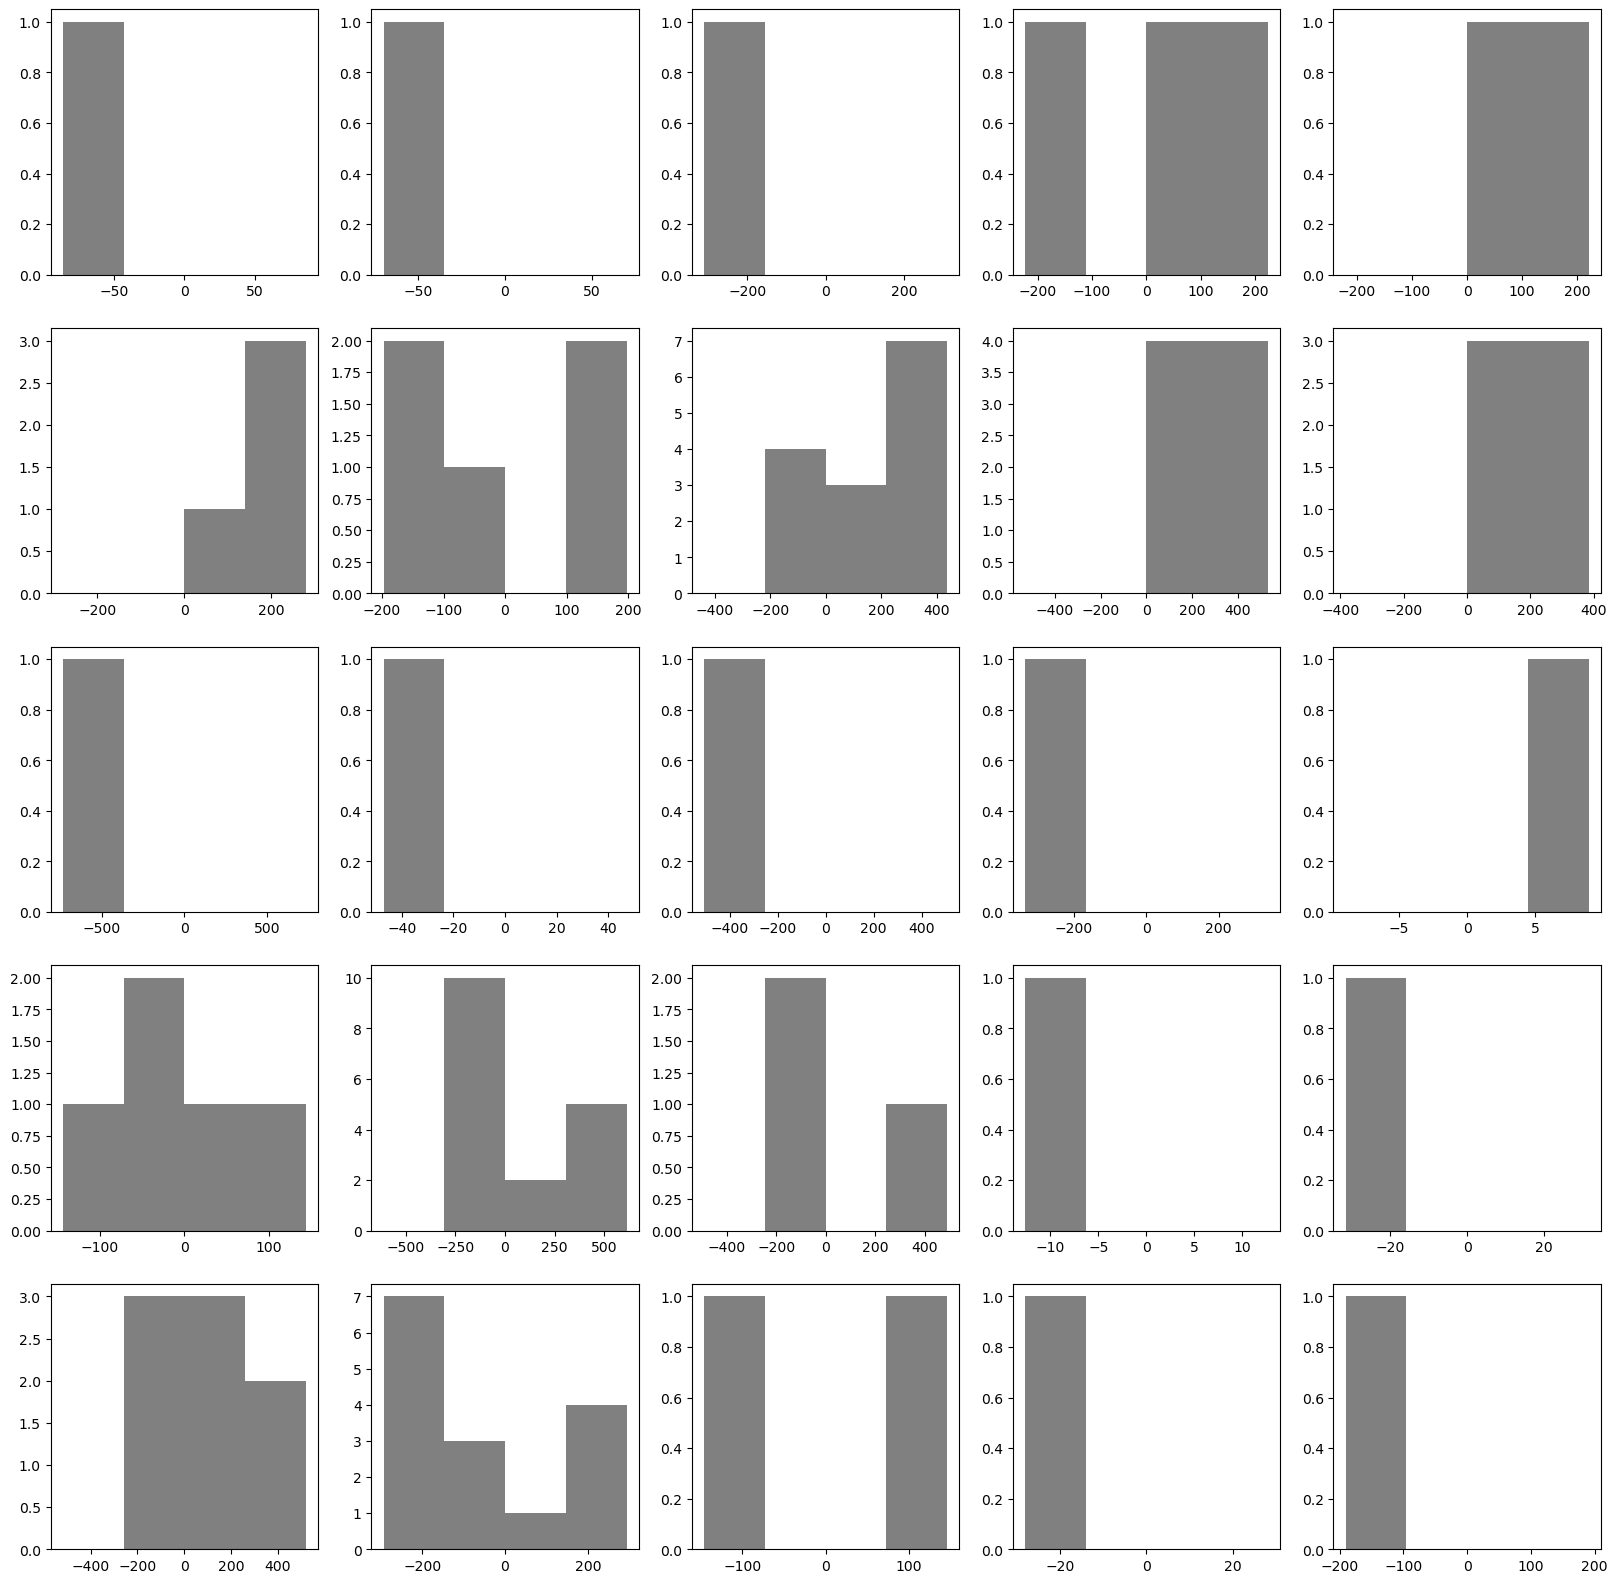

In [14]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=[20, 20])
c = 0
for i in range(len(results)):
    if len(results.distance[i]) > 1:
        if c < 25:
            axs[c//5, c%5].hist(results.distance[i], bins=np.linspace(-np.abs(results.distance[i].max()), np.abs(results.distance[i].max()), 5), color="gray")
        c += 1

**Conclusion :** No pattern identified → each distances distribution is approximated by its mean value and associated to the corresponding uncertainty.

In [15]:
results.loc[:, "mean_distance"] = results.distance.apply(lambda x: np.array(x).mean())
results.loc[:, "uncertainty"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties.loc[(uncertainties.year_1 == x.iloc[0]) & (uncertainties.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results.loc[:, "years"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results = results[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,4,1962,1963,"(1962, 1963)","[-86.23007513843609, -396.32188237109665]",-241.275979,825.692437
1,4,1962,1976,"(1962, 1976)","[-1450.7132367907936, -1511.82316731564, -70.0...",-924.789543,770.186990
2,4,1963,1976,"(1963, 1976)","[-422.5270542819276, -470.5395858628364, -310....",-664.223629,337.146852
3,25,1962,1963,"(1962, 1963)","[52.934303303832884, -308.1062720617464, 223.5...",-39.310605,825.692437
4,25,1962,1976,"(1962, 1976)","[76.82899443702789, 220.5166627894711]",148.672829,770.186990
...,...,...,...,...,...,...,...
434,87,1976,1978,"(1976, 1978)",[-91.97451945462406],-91.974519,198.595065
435,82,1976,1978,"(1976, 1978)",[-153.44472935472436],-153.444729,198.595065
436,66,1976,1978,"(1976, 1978)",[-72.56704667293884],-72.567047,198.595065
437,72,1976,1978,"(1976, 1978)",[-33.72669053388882],-33.726691,198.595065


In [16]:
# horrible way to plot a summary of the results, but I could not find better.
results_overview = pd.DataFrame(
    [],
    columns=["years", "uncertainty", "count"]
)
results_overview.loc[:, "years"] = results.years.unique()
results_overview.loc[:, "uncertainty"] = results.uncertainty.unique()
results_overview.loc[:, "count"] = results.years.value_counts().values
results_overview

,years,uncertainty,count
0,"(1962, 1963)",825.692437,100
1,"(1962, 1976)",770.18699,94
2,"(1963, 1976)",337.146852,68
3,"(1963, 1978)",357.798826,65
4,"(1976, 1978)",198.595065,62
5,"(1962, 1978)",779.448523,50


Compare results tu uncertainties to identify trustworthy examples

62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


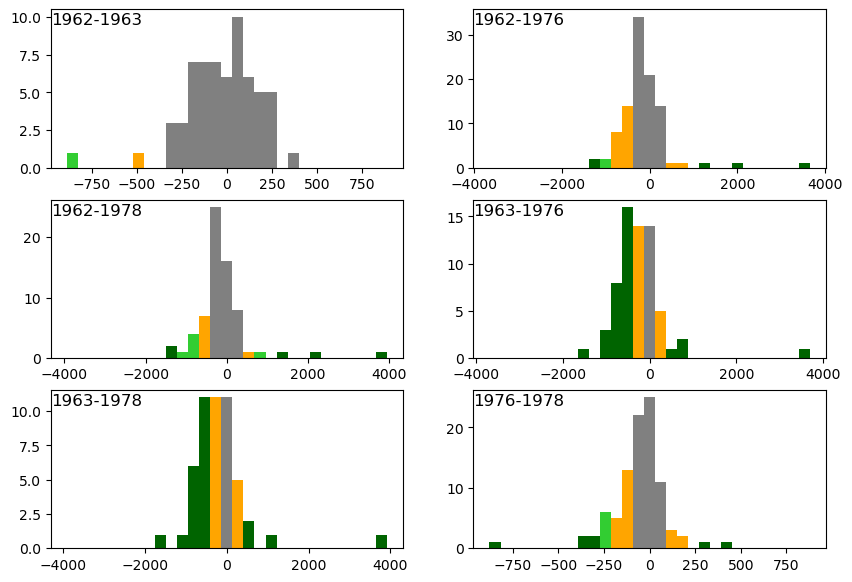

In [103]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions.png", bbox_inches="tight")

62 -25.64493951798229 202.68955163617233
100 -144.3029461553655 577.9798141277005
68 -103.46106983241184 714.7724608579525
65 -242.87406537842466 638.818181857793
50 -195.08917853911626 739.0742261257744
94 -56.48980003531667 149.42638623089078


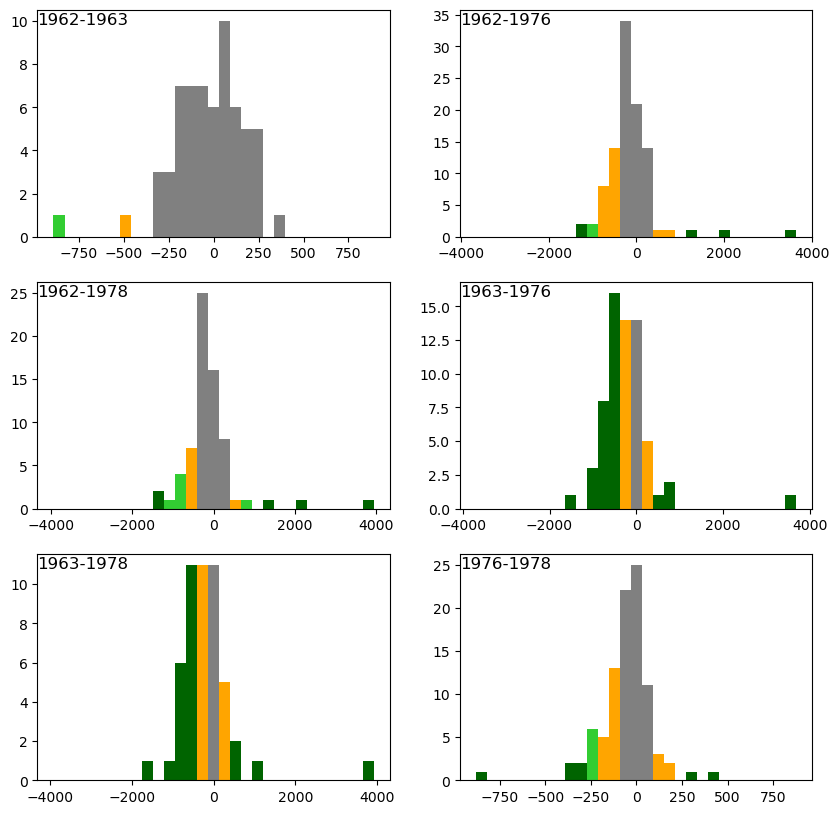

In [102]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_big.png", bbox_inches="tight")

Split trustworthy surges and retreats in separate datasets

In [56]:
# list of surges and retreats

surges = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
    res = results.where(results.loc[results.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges = pd.concat([surges, surges_1])
    if not retreats_1.empty:
        retreats = pd.concat([retreats, retreats_1])
        
surges

C:\Users\loris\AppData\Local\Temp\ipykernel_19208\2778544960.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats = pd.concat([retreats, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_19208\2778544960.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges = pd.concat([surges, surges_1])


,front_id,years,mean_distance,uncertainty
253,122,"(1962, 1976)",3652.623886,770.186990
307,121,"(1962, 1976)",1962.144474,770.186990
350,123,"(1962, 1976)",1312.976490,770.186990
250,120,"(1962, 1978)",883.417455,779.448523
254,122,"(1962, 1978)",3943.133563,779.448523
308,121,"(1962, 1978)",2084.629828,779.448523
351,123,"(1962, 1978)",1280.833637,779.448523
8,26,"(1963, 1976)",350.129044,337.146852
116,56,"(1963, 1976)",719.102820,337.146852
193,91,"(1963, 1976)",626.482327,337.146852


In [57]:
retreats

,front_id,years,mean_distance,uncertainty
421,105,"(1962, 1963)",-890.374373,825.692437
1,4,"(1962, 1976)",-924.789543,770.186990
42,37,"(1962, 1976)",-1211.339623,770.186990
102,54,"(1962, 1976)",-857.949856,770.186990
281,144,"(1962, 1976)",-879.637575,770.186990
...,...,...,...,...
395,76,"(1976, 1978)",-276.712853,198.595065
397,73,"(1976, 1978)",-224.729630,198.595065
398,74,"(1976, 1978)",-333.632579,198.595065
403,93,"(1976, 1978)",-385.232690,198.595065


In [58]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges.front_id.unique()), surges.front_id.unique(), len(retreats.front_id.unique()), retreats.front_id.unique()

(9,
 array([122, 121, 123, 120, 26, 56, 91, 93, 165], dtype=object),
 49,
 array([105, 4, 37, 54, 144, 42, 109, 73, 154, 28, 29, 38, 40, 41, 50, 51,
        52, 53, 58, 59, 180, 111, 141, 161, 139, 140, 178, 142, 160, 2, 95,
        96, 97, 106, 32, 33, 49, 108, 113, 116, 136, 43, 62, 61, 60, 76,
        74, 93, 89], dtype=object))

**Conclusion :**
- The method seem to work in general
- There is (apparently) one bad example of detected surge

**To Do :**
- Re-check all cases
- Build a dataset of when the surges happened
- Compare with another method (e.g. box method).

## Box method

### First tests

In [41]:
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00663,RGI2000-v7.0-G-07-00016,27,W,"LINESTRING (417320.52 8806789.925, 417358.417 ..."


In [42]:
boxes = gpd.read_file(posixpath.join(data_root, "boxes/boxes.shp")).to_crs(epsg=25833)
boxes.head()

,front_id,front_dir,RGI60ID,RGI70ID,geometry
0,1,NE,RGI60-07.01494,RGI2000-v7.0-G-07-00054,"POLYGON ((448958.093 8831407.133, 451132.965 8..."
1,2,NE,RGI60-07.00791,RGI2000-v7.0-G-07-01223,"POLYGON ((448556.464 8831393.624, 447609.196 8..."
2,3,E,RGI60-07.00777,RGI2000-v7.0-G-07-01225,"POLYGON ((446223.949 8833013.329, 449012.234 8..."
3,4,SE,RGI60-07.00775,RGI2000-v7.0-G-07-01229,"POLYGON ((445849.929 8838239.577, 448611.174 8..."
4,5,NE,RGI60-07.00794,RGI2000-v7.0-G-07-01268,"POLYGON ((444478.132 8842149.605, 443352.455 8..."


In [43]:
fronts_i = all_fronts.loc[all_fronts.front_id == 52]
fronts_i

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
25,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482907.211 8713010.646, 482911.001..."
81,DS09058A024MC013,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482953.714 8712928.344, 483061.461..."
243,DS09034A008MC022,KH-5 ARGON 9034A,1962-05-16,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (483353.81 8712332.201, 483280.998 ..."
627,LM02_L1GS_239002_19760709_20200907_02_T2,Landsat 2 MSS,1976-07-09,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482828.179 8713133.73, 482861.804 ..."
634,LM02_L1GS_240002_19760710_20200907_02_T2,Landsat 2 MSS,1976-07-10,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482862.657 8713011.896, 482866.66 ..."
833,LM03_L1GS_238003_19780812_20210611_02_T2,Landsat 3 MSS,1978-08-12,RGI60-07.00465,RGI2000-v7.0-G-07-00354,52,E,"LINESTRING (482704.683 8713062.28, 482768.992 ..."


[[ 487855.85190003 8713300.19571801]
 [ 481422.78938224 8711594.19018843]] [8713300.19571801 8711594.19018843]
Distance between fronts 0 and 3 is -584.09 m, with area1 = 3727731.88 m^2, area2 = 2738724.35 m^2, base length = 1693.25 m.


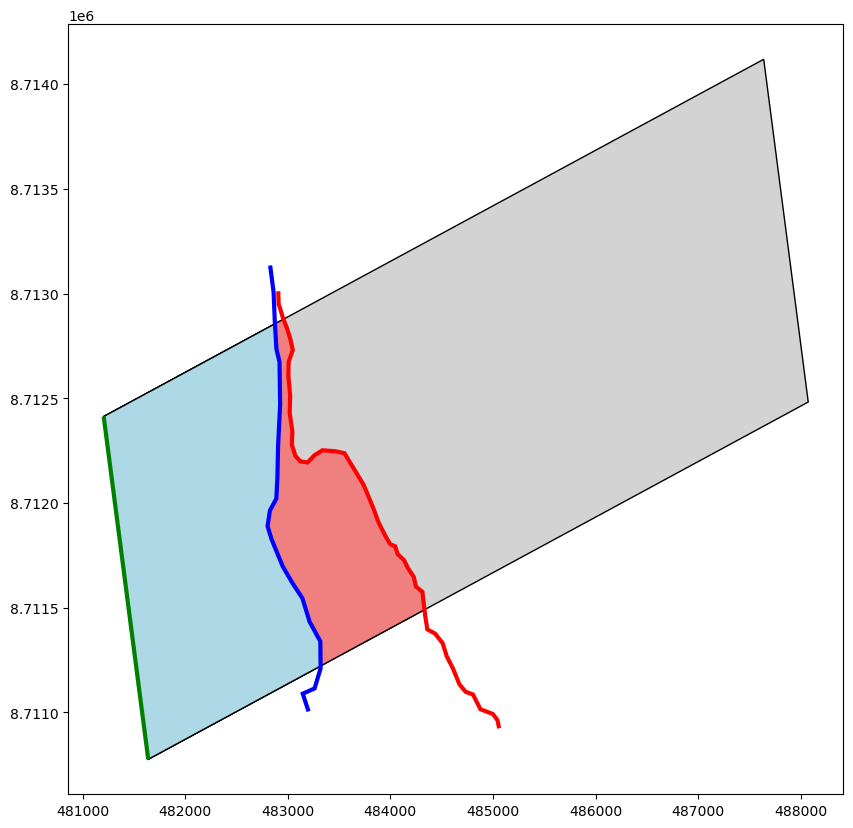

In [44]:
ia, ib = 0, 3

front1, front2 = fronts_i.iloc[ia].geometry, fronts_i.iloc[ib].geometry
dir1, dir2 = fronts_i.iloc[ia].front_dir, fronts_i.iloc[ib].front_dir
u = np.array([0, 1])
box = boxes.loc[boxes.front_id == fronts_i.iloc[ia].front_id].geometry.values[0]

inter1, inter2 = shapely.intersection(front1, box.exterior), shapely.intersection(front2, box.exterior)
if isinstance(inter1, shapely.Point):
    inter1 = shapely.MultiPoint([inter1])
if isinstance(inter2, shapely.Point):
    inter2 = shapely.MultiPoint([inter2])
    
assert(not inter1.is_empty), "Intersection of front 1 with the box is empty."
assert(not inter2.is_empty), "Intersection of front 2 with the box is empty."
    
assert(len(list(inter1.geoms)) >= 2), "Intersection of front 1 with the box should be a line."
assert(len(list(inter2.geoms)) >= 2), "Intersection of front 2 with the box should be a line."

# method 1 : dot product with points 1 by 1: doesn't work
# box_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in box.exterior.coords])[:-1, :]
# u_dot_box = np.sum(box_points * np.stack([u, u, u, u], axis=0), axis=1)
# print(box_points)
# print(u_dot_box)

# i1 = np.argmin(u_dot_box, axis=0)
# u_dot_box_cpy = np.copy(u_dot_box)
# u_dot_box_cpy[i1] = np.inf
# i2 = np.argmin(u_dot_box_cpy, axis=0)

# base_points = np.stack([box_points[i1], box_points[i2]])


# method 2 : intersection with fronts + dot product with u: works!
box_sides = [shapely.LineString([box.exterior.coords[i], box.exterior.coords[i + 1]]) for i in range(len(box.exterior.coords) - 1)]
possible_base = [box_sides[i] for i in range(len(box_sides)) if not shapely.intersects(box_sides[i], front1)]
possible_base_centers = np.array([[shapely.centroid(possible_base[i]).x, shapely.centroid(possible_base[i]).y] for i in range(len(possible_base))])
u_dot_c = np.sum(possible_base_centers * np.stack([u, u], axis=0), axis=1)

base = possible_base[np.argmin(u_dot_c)]
print(possible_base_centers, u_dot_c)
# base_points = np.array([[shapely.Point(coords).x, shapely.Point(coords).y] for coords in base.coords])


# cropped fronts
front1_crop = shapely.intersection(front1, box)
front2_crop = shapely.intersection(front2, box)

if isinstance(front1_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front1_crop.geoms]
    front1_crop = lines[np.argmax([line.length for line in lines])]
if isinstance(front2_crop, shapely.MultiLineString):
    lines = [shapely.LineString(line) for line in front2_crop.geoms]
    front2_crop = lines[np.argmax([line.length for line in lines])]

# distance
points_1 = [shapely.Point(coords) for coords in front1_crop.coords]
points_2 = [shapely.Point(coords) for coords in front2_crop.coords]
base_points = [shapely.Point(coords) for coords in base.coords]

if shapely.distance(points_1[0], base_points[0]) > shapely.distance(points_1[0], base_points[-1]):
    points_1 = points_1[::-1]
    front1_crop = shapely.LineString(points_1)
    
if shapely.distance(points_2[0], base_points[0]) > shapely.distance(points_2[0], base_points[-1]):
    points_2 = points_2[::-1]
    front2_crop = shapely.LineString(points_2)
    
polygon1 = shapely.Polygon(list(front1_crop.coords) + list(base.coords[::-1]))
polygon2 = shapely.Polygon(list(front2_crop.coords) + list(base.coords[::-1]))
area1 = polygon1.area
area2 = polygon2.area
d = (area2 - area1)/base.length

print(f"Distance between fronts {ia} and {ib} is {d:.2f} m, with area1 = {area1:.2f} m^2, area2 = {area2:.2f} m^2, base length = {base.length:.2f} m.")


## plots
fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_polygon(box, facecolor="lightgray", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon1, facecolor="lightcoral", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_polygon(polygon2, facecolor="lightblue", edgecolor="k", add_points=False, ax=ax)
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(base, color="green", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[0], color="orange", add_points=False, linewidth=3, ax=ax)
# shapely.plotting.plot_line(possible_base[1], color="orange", add_points=False, linewidth=3, ax=ax)
# ax.scatter(possible_base_centers[:, 0], possible_base_centers[:, 1], color="black", s=10, label="possible base centers")

### Definition of functions

In [45]:
def box_distance(front1, front2, box, dir_1, dir_2):
    '''
    Implements the box distance between two fronts, given the box and the direction of the fronts.
    Returns the distance and an error code:
    - 0 : success
    - 1 : fronts do not intersect twice with the box sides.
    '''
    # Sanity check : fronts must have the same direction.
    assert dir_1 == dir_2, "Fronts must have the same direction"
    
    # transform direction into av vector:
    if dir_1 == "N":
        u = np.array([0, 1])
    elif dir_1 == "S":
        u = np.array([0, -1])
    elif dir_1 == "E":
        u = np.array([1, 0])
    elif dir_1 == "W":
        u = np.array([-1, 0])
    elif dir_1 == "NE":
        u = np.array([1, 1]) / np.sqrt(2)
    elif dir_1 == "NW":
        u = np.array([-1, 1]) / np.sqrt(2)
    elif dir_1 == "SE":
        u = np.array([1, -1]) / np.sqrt(2)
    elif dir_1 == "SW":
        u = np.array([-1, -1]) / np.sqrt(2)
    else:
        raise ValueError(f"Unknown direction: {dir_1}")
    
    inter1, inter2 = shapely.intersection(front1, box.exterior), shapely.intersection(front2, box.exterior)
    if isinstance(inter1, shapely.Point):
        inter1 = shapely.MultiPoint([inter1])
    if isinstance(inter2, shapely.Point):
        inter2 = shapely.MultiPoint([inter2])
    
    if inter1.is_empty or inter2.is_empty:
        return None, 1    
    elif (len(list(inter1.geoms)) < 2) or (len(list(inter2.geoms)) < 2):
        return None, 1
    else:
        # find the base of the box:
        # 1 - separate the box into sides
        box_sides = [shapely.LineString([box.exterior.coords[i], box.exterior.coords[i + 1]]) for i in range(len(box.exterior.coords) - 1)]
        # 2 - exclude sides that intersect with the fronts and calculate the centers of the others 
        possible_base = [box_sides[i] for i in range(len(box_sides)) if not shapely.intersects(box_sides[i], front1)]
        possible_base_centers = np.array([[shapely.centroid(possible_base[i]).x, shapely.centroid(possible_base[i]).y] for i in range(len(possible_base))])
        # 3 - calculate the dot product of the centroid of the sides with the vector and minimize it to find the base
        u_dot_c = np.sum(possible_base_centers * np.stack([u, u], axis=0), axis=1)
        base = possible_base[np.argmin(u_dot_c)]

        # cropped fronts
        front1_crop = shapely.intersection(front1, box)
        front2_crop = shapely.intersection(front2, box)
        
        if isinstance(front1_crop, shapely.MultiLineString):
            lines = [shapely.LineString(line) for line in front1_crop.geoms]
            front1_crop = lines[np.argmax([line.length for line in lines])]
        if isinstance(front2_crop, shapely.MultiLineString):
            lines = [shapely.LineString(line) for line in front2_crop.geoms]
            front2_crop = lines[np.argmax([line.length for line in lines])]

        # distance
        points_1 = [shapely.Point(coords) for coords in front1_crop.coords]
        points_2 = [shapely.Point(coords) for coords in front2_crop.coords]
        base_points = [shapely.Point(coords) for coords in base.coords]
        # change the order of the points if necessary to avoid negative area
        if shapely.distance(points_1[0], base_points[0]) > shapely.distance(points_1[0], base_points[-1]):
            points_1 = points_1[::-1]
            front1_crop = shapely.LineString(points_1)
            
        if shapely.distance(points_2[0], base_points[0]) > shapely.distance(points_2[0], base_points[-1]):
            points_2 = points_2[::-1]
            front2_crop = shapely.LineString(points_2)
            
        polygon1 = shapely.Polygon(list(front1_crop.coords) + list(base.coords[::-1]))
        polygon2 = shapely.Polygon(list(front2_crop.coords) + list(base.coords[::-1]))
        area1 = polygon1.area
        area2 = polygon2.area
        return (area2 - area1)/base.length, 0


### Uncertainties

Timestamp: 1962-05-16 00:00:00, Mean distance: -47.89 m, Standard deviation: 710.36 m
Timestamp: 1963-08-29 00:00:00, Mean distance: -14.23 m, Standard deviation: 304.62 m
Skipped 88 comparisons out of 516.


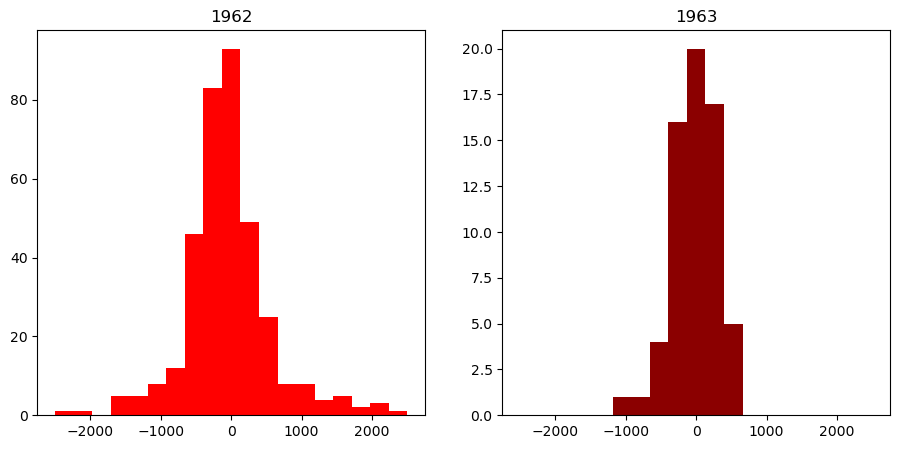

In [105]:
dists = []
skip_count = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = box_distance(front1, front2, box, dir_1, dir_2)
                    # if dist == np.nan:
                    #     print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                    if dist is not None:
                        dists_timestamp.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")

print(f"Skipped {skip_count} comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"))
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"))
# fig.suptitle("Distribution of distances between KH-5 ARGON fronts")
fig.savefig("images/KH-5_ARGON_fonts_accuracy_box.png", bbox_inches="tight")

Year: 1976, Mean distance: -15.85 m, Standard deviation: 135.86 m
Year: 1978, Mean distance: -4.80 m, Standard deviation: 139.03 m
Skipped 108 comparisons out of 337.


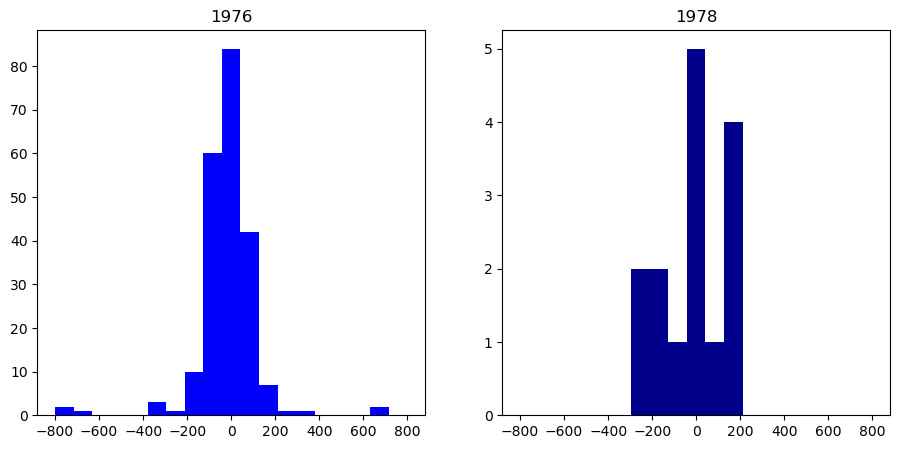

In [104]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                    box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                    dist, e = box_distance(front1, front2, box, dir_1, dir_2)
                    if dist is not None:
                        dists_year.append(dist)
                    elif e == 1:
                        skip_count += 1
                else:
                    skip_count += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")

print(f"Skipped {skip_count} comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(years), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0])
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1])
# fig.suptitle("Distribution of distances between Landsat MSS fronts")
fig.savefig("images/Landsat_MSS_fonts_accuracy_box.png", bbox_inches="tight")

In [48]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[710. 304. 135. 139.] [502. 214.  95.  98.]


In [49]:
uncertainties_box = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties_box.loc[len(uncertainties_box)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        
uncertainties_box.loc[:, "years"] = uncertainties_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties_box = uncertainties_box[["year_1", "year_2", "years", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties_box

,year_1,year_2,years,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,"(1962.0, 1962.0)",709.935208,1419.870417,2129.805625
1,1962.0,1963.0,"(1962.0, 1963.0)",545.710546,1091.421092,1637.131638
2,1962.0,1976.0,"(1962.0, 1976.0)",510.909973,1021.819945,1532.729918
3,1962.0,1978.0,"(1962.0, 1978.0)",511.476295,1022.952589,1534.428884
4,1963.0,1963.0,"(1963.0, 1963.0)",302.641702,605.283405,907.925107
5,1963.0,1976.0,"(1963.0, 1976.0)",234.138848,468.277695,702.416543
6,1963.0,1978.0,"(1963.0, 1978.0)",235.372046,470.744092,706.116138
7,1976.0,1976.0,"(1976.0, 1976.0)",134.350288,268.700577,403.050865
8,1976.0,1978.0,"(1976.0, 1978.0)",136.488095,272.976189,409.464284


### Results

In [50]:
results_box = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count = 0
total_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    try:
                        if not boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].empty:
                            box = boxes.loc[boxes.front_id == fronts.front_id.iloc[k]].geometry.values[0]
                            dist, e = box_distance(front1, front2, box, dir_1, dir_2)
                            if dist is not None:
                                dists.append(dist)
                            elif e == 1:
                                skip_count += 1
                        else:
                            skip_count += 1
                    except AssertionError:
                        skip_count += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results_box = pd.concat([results_box, results_i])
            
print(f"Skipped {skip_count} comparisons out of {total_count}.")
results_box.reset_index(drop=True, inplace=True)
results_box = results_box.dropna().reset_index(drop=True)


results_box.loc[:, "mean_distance"] = results_box.distance.apply(lambda x: np.array(x).mean())
results_box.loc[:, "uncertainty"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties_box.loc[(uncertainties_box.year_1 == x.iloc[0]) & (uncertainties_box.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results_box.loc[:, "years"] = results_box.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results_box = results_box[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results_box

Skipped 658 comparisons out of 2019.


,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695
...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189


In [51]:
results_box.value_counts("years")

years
(1962, 1976)    102
(1976, 1978)     89
(1962, 1978)     73
(1963, 1976)     70
(1962, 1963)     56
(1963, 1978)     50
Name: count, dtype: int64

56 -15.919301291419938 285.7828987448423
102 -285.23734828895147 815.2434204924118
73 -336.1466414434039 1025.12996197374
70 -294.4745160263729 965.4967540816172
50 -266.07918558537256 1092.0789001175115
89 -86.6713609533038 217.27608530068864


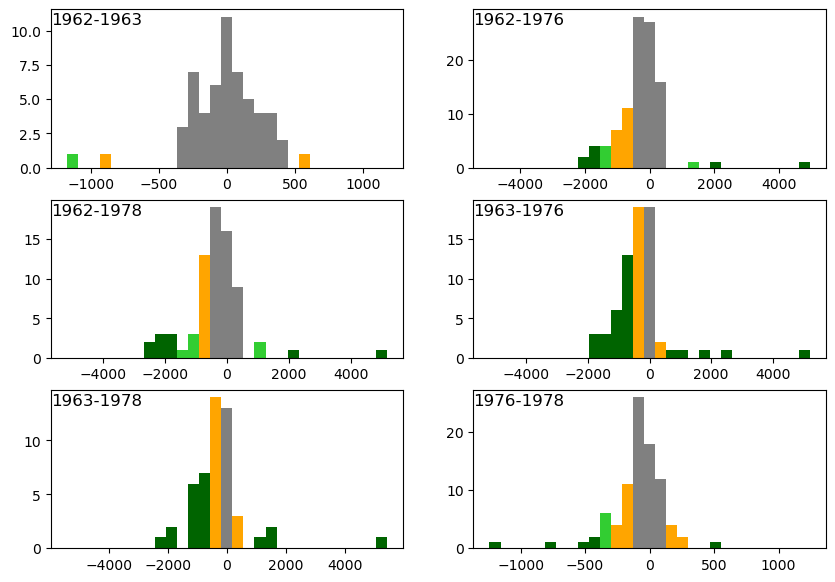

In [101]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 7))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.85, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box.png", bbox_inches="tight")

56 -15.919301291419938 285.7828987448423
102 -285.23734828895147 815.2434204924118
73 -336.1466414434039 1025.12996197374
70 -294.4745160263729 965.4967540816172
50 -266.07918558537256 1092.0789001175115
89 -86.6713609533038 217.27608530068864


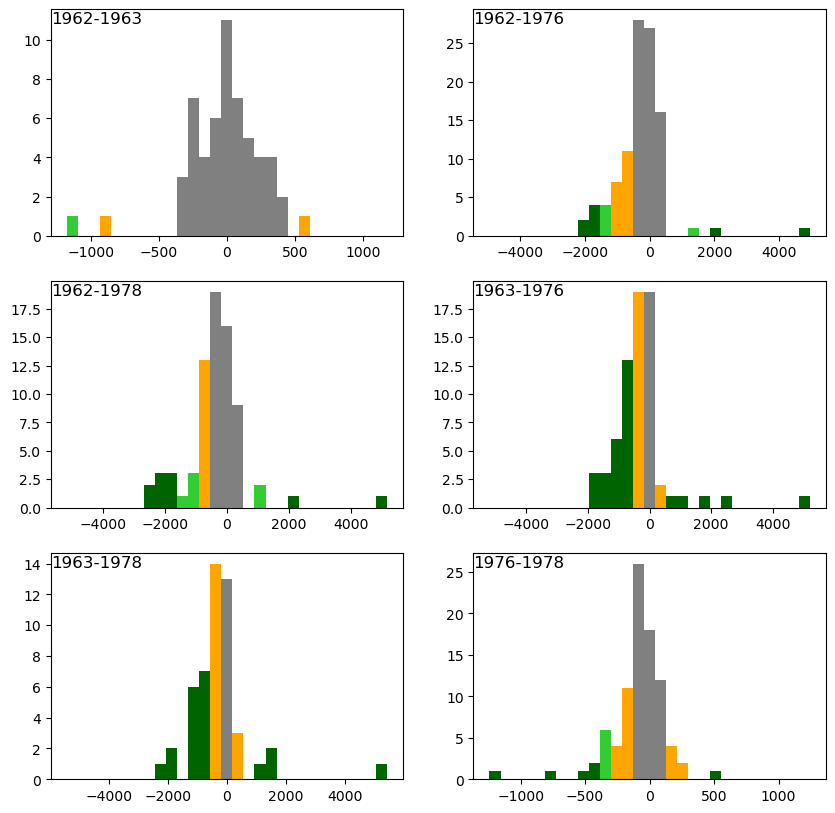

In [100]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results_box.loc[results_box.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}", y=0.9, loc="left")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions_box_big.png", bbox_inches="tight")

In [53]:
# list of surges and retreats

surges_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats_box = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties_box.loc[uncertainties_box.years == years]["sigma_dist"].values[0]
    res = results_box.where(results_box.loc[results_box.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges_box = pd.concat([surges_box, surges_1])
    if not retreats_1.empty:
        retreats_box = pd.concat([retreats_box, retreats_1])
        
surges_box

C:\Users\loris\AppData\Local\Temp\ipykernel_19208\3083962847.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats_box = pd.concat([retreats_box, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_19208\3083962847.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges_box = pd.concat([surges_box, surges_1])


,front_id,years,mean_distance,uncertainty
113,56,"(1962, 1976)",1281.064771,1021.819945
254,122,"(1962, 1976)",4936.214159,1021.819945
307,121,"(1962, 1976)",2153.329321,1021.819945
114,56,"(1962, 1978)",1118.781515,1022.952589
255,122,"(1962, 1978)",5174.801442,1022.952589
308,121,"(1962, 1978)",2279.420071,1022.952589
115,56,"(1963, 1976)",1159.852106,468.277695
194,91,"(1963, 1976)",775.398523,468.277695
256,122,"(1963, 1976)",5198.308320,468.277695
398,92,"(1963, 1976)",1823.102178,468.277695


In [54]:
retreats_box

,front_id,years,mean_distance,uncertainty
419,105,"(1962, 1963)",-1175.502816,1091.421092
40,37,"(1962, 1976)",-1401.692189,1021.819945
101,54,"(1962, 1976)",-1542.028761,1021.819945
223,161,"(1962, 1976)",-1023.359882,1021.819945
287,42,"(1962, 1976)",-1180.570938,1021.819945
...,...,...,...,...
391,73,"(1976, 1978)",-386.318624,272.976189
394,74,"(1976, 1978)",-381.492736,272.976189
400,92,"(1976, 1978)",-383.159906,272.976189
403,93,"(1976, 1978)",-805.205309,272.976189


In [59]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges_box.front_id.unique()), surges_box.front_id.unique(), len(retreats_box.front_id.unique()), retreats_box.front_id.unique()

(8,
 array([56, 122, 121, 91, 92, 93, 120, 165], dtype=object),
 48,
 array([105, 37, 54, 161, 42, 109, 62, 76, 73, 74, 75, 95, 106, 154, 144,
        4, 28, 38, 41, 50, 51, 52, 53, 58, 180, 111, 141, 138, 139, 140,
        178, 142, 160, 2, 96, 97, 98, 33, 46, 49, 116, 124, 34, 43, 60, 92,
        93, 89], dtype=object))

## Method comparison

In [86]:
for i in results_box.index.values:
    front_id, year1, year2 = results_box.loc[i][["front_id", "year_1", "year_2"]]
    for j in results.index.values:
        front_id_2, year1_2, year2_2 = results_box.loc[j][["front_id", "year_1", "year_2"]]
        if (front_id == front_id_2) and (year1 == year1_2) and (year2 == year2_2):
            results_box.loc[i, "mean_distance_2"] = results.loc[j, "mean_distance"]
            results_box.loc[i, "uncertainty_2"] = results.loc[j, "uncertainty"]
            
results_box

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty,mean_distance_2,uncertainty_2
0,3,1963,1976,"(1963, 1976)","[-341.26830933591924, -463.03829475751604]",-402.153302,468.277695,-241.275979,825.692437
1,4,1963,1976,"(1963, 1976)","[-501.3441551864909, -545.3417011649898, -367....",-776.636692,468.277695,-924.789543,770.186990
2,25,1962,1963,"(1962, 1963)","[104.29363221683396, 260.1996766181235]",182.246654,1091.421092,-664.223629,337.146852
3,25,1962,1976,"(1962, 1976)","[251.13957302078396, 269.4042203817791, 81.303...",278.568870,1021.819945,-39.310605,825.692437
4,25,1963,1976,"(1963, 1976)","[146.84594080395, 165.11058816494514, -22.9898...",96.322216,468.277695,148.672829,770.186990
...,...,...,...,...,...,...,...,...,...
435,65,1976,1978,"(1976, 1978)",[-114.31890299647765],-114.318903,272.976189,-153.444729,198.595065
436,66,1976,1978,"(1976, 1978)",[-85.73270102390168],-85.732701,272.976189,-72.567047,198.595065
437,72,1976,1978,"(1976, 1978)",[-36.90731420880558],-36.907314,272.976189,-33.726691,198.595065
438,79,1976,1978,"(1976, 1978)",[-87.25323145609863],-87.253231,272.976189,-75.400310,198.595065


In [91]:
results_cross = results_box.loc[:, ["front_id", "year_1", "year_2", "years", "mean_distance", "mean_distance_2", "uncertainty", "uncertainty_2"]]
results_cross.columns = ["front_id", "year_1", "year_2", "years", "mean_distance_box", "mean_distance_manual", "uncertainty_box", "uncertainty_manual"]
results_cross.dropna(inplace=True)
results_cross

,front_id,year_1,year_2,years,mean_distance_box,mean_distance_manual,uncertainty_box,uncertainty_manual
0,3,1963,1976,"(1963, 1976)",-402.153302,-241.275979,468.277695,825.692437
1,4,1963,1976,"(1963, 1976)",-776.636692,-924.789543,468.277695,770.186990
2,25,1962,1963,"(1962, 1963)",182.246654,-664.223629,1091.421092,337.146852
3,25,1962,1976,"(1962, 1976)",278.568870,-39.310605,1021.819945,825.692437
4,25,1963,1976,"(1963, 1976)",96.322216,148.672829,468.277695,770.186990
...,...,...,...,...,...,...,...,...
434,82,1976,1978,"(1976, 1978)",-136.123419,-91.974519,272.976189,198.595065
435,65,1976,1978,"(1976, 1978)",-114.318903,-153.444729,272.976189,198.595065
436,66,1976,1978,"(1976, 1978)",-85.732701,-72.567047,272.976189,198.595065
437,72,1976,1978,"(1976, 1978)",-36.907314,-33.726691,272.976189,198.595065


In [92]:
scipy.stats.linregress(
    results_cross.mean_distance_box,
    results_cross.mean_distance_manual
)

LinregressResult(slope=0.3658408618648422, intercept=-42.74411748948775, rvalue=0.5431427134089073, pvalue=4.7096284220368577e-35, stderr=0.02705396100380733, intercept_stderr=22.40278651704487)

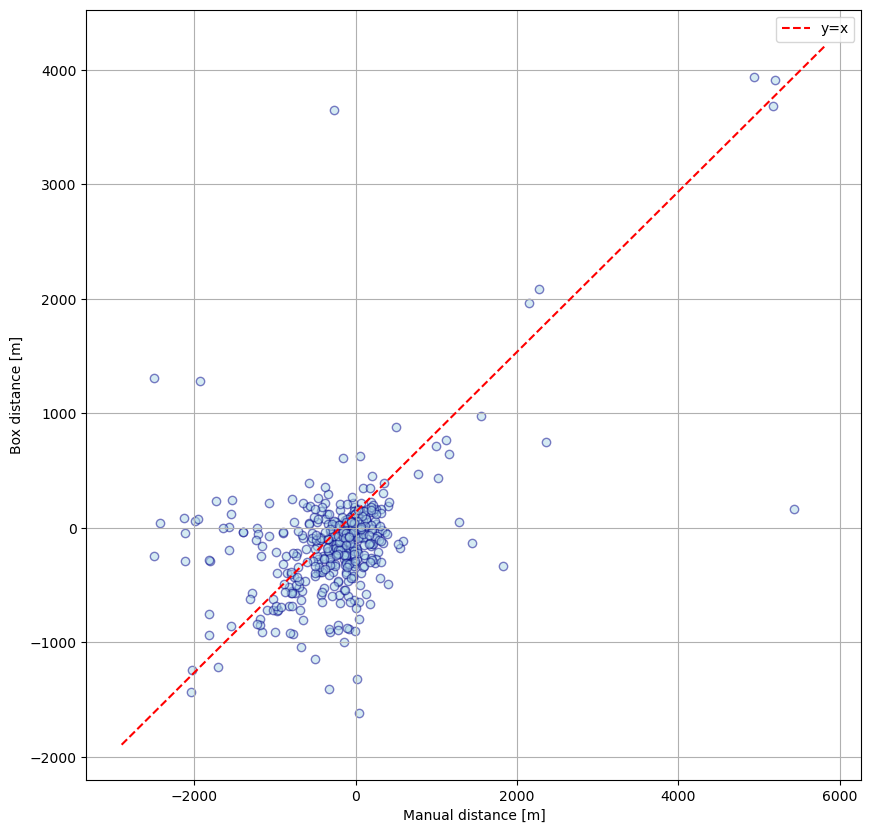

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(results_cross.mean_distance_box, results_cross.mean_distance_manual, color="lightblue", edgecolor="darkblue", alpha=0.5)
ax.plot(ax.get_xlim(), ax.get_ylim(), color="red", linestyle="--", label="y=x")
ax.grid()
ax.legend()
ax.set_xlabel("Manual distance [m]")
ax.set_ylabel("Box distance [m]")
fig.savefig("images/results_cross_distances.png", bbox_inches="tight")